In [1]:
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np

# Loading the data

In [2]:
df = pd.Series()
df['raw'] = pd.read_csv('./Data/clean.csv',index_col='Time_Stamp',low_memory=False)
#df['area'] = pd.read_csv('./Data/area.csv',index_col='Time stamp',low_memory=False)
df['raw'].shape

(38709, 6)

In [3]:
df['raw'].head()

,Weekday,Area,Sub_Area,Free_Spots,Used_Spots,Full%
Time_Stamp,,,,,,
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E MARION ST AND E SPRING ST,12.0,0.0,0.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E COLUMBIA ST AND E MARION ST,13.0,7.0,35.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E SPRING ST AND E MADISON ST,15.0,4.0,21.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E JAMES CT AND E CHERRY ST,4.0,2.0,33.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E BARCLAY CT AND E JAMES CT,8.0,0.0,0.0


# Data exploration

Because this is an example, i will choose one specific parking area to predict. 

## Choosing the area

For reference, i will investigate the content of Parking_Spaces, as it is not clear what this means.

In [4]:
df['raw']['Sub_Area'].value_counts().head()

NW 54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST        77
NW 54TH SR ST BETWEEN 30TH WR AVE NW AND 32ND AVE NW    75
MAYNARD AVE S BETWEEN S JACKSON ST AND S KING ST        67
7TH AVE S BETWEEN S MAIN ST AND S JACKSON ST            67
MAYNARD AVE S BETWEEN S KING ST AND S WELLER ST         66
Name: Sub_Area, dtype: int64

54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST is the parking spot with the most entries. These entries will be the ones used for modeling.

In [5]:
df['data'] = df['raw'][df['raw']['Sub_Area'].isin({'NW 54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST'})]

## Exploration

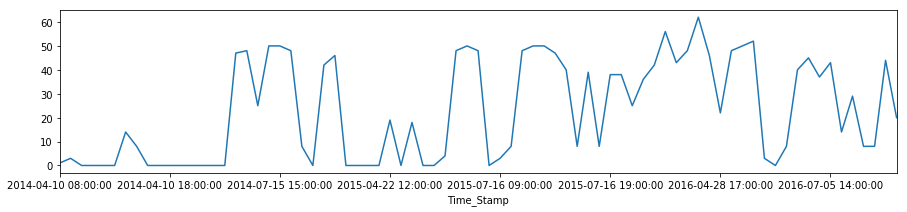

In [6]:
#Time series plot
plt.figure(figsize=(15,3));
df['data']['Full%'].plot();
plt.show();


In [7]:
df['data']['Free_Spots'].value_counts().head(10)

12.0     28
24.0     14
68.0     13
136.0    12
7.0       3
6.0       2
14.0      1
3.0       1
22.0      1
13.0      1
Name: Free_Spots, dtype: int64

Entire dataset


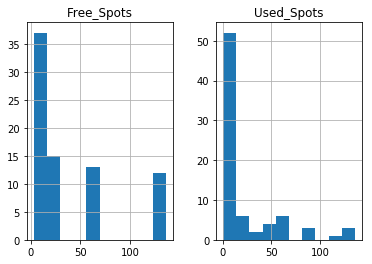

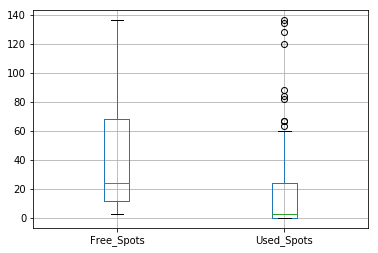

In [8]:
print('Entire dataset')
df['data'][['Free_Spots','Used_Spots']].hist()
plt.show()
df['data'][['Free_Spots','Used_Spots']].boxplot()
plt.show()

Weekdays


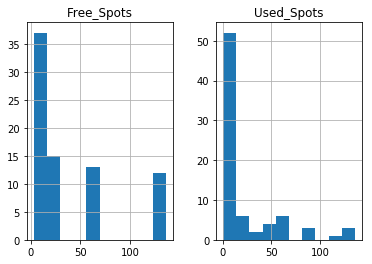

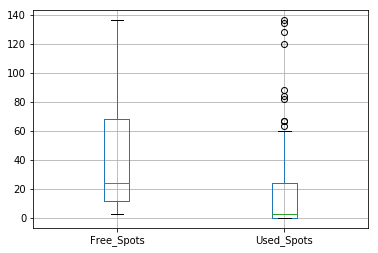

In [9]:
print('Weekdays')
obj = df['data'][df['data'].Weekday.isin({'Yes'})]
obj[['Free_Spots','Used_Spots']].hist()
plt.show()
obj[['Free_Spots','Used_Spots']].boxplot()
plt.show()

Weekends


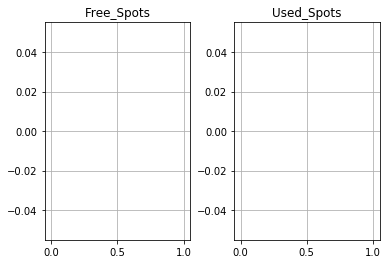

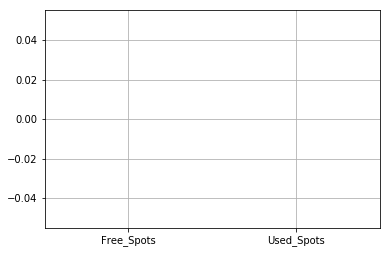

In [10]:
print('Weekends')
obj = df['data'][df['data'].Weekday.isin({'No'})]
obj[['Free_Spots','Used_Spots']].hist()
plt.show()
obj[['Free_Spots','Used_Spots']].boxplot()
plt.show()

The boxplots tell me that all observations was made on weekdays. This means i will not be able to guratantee the performance of weekends, as i cant validate the model on these days, and cannot look for differences between weekdays and weekends.

# Modeling

## Test train split
Before any modeling is done, the dataset will be spit into a test/train set.

In [11]:
from sklearn.model_selection import train_test_split
TRAIN,TEST,notused,notused = train_test_split(df['data']['Full%'],
                                                    df['data']['Full%'], 
                                                    test_size=0.25)
TRAIN.sort_index(inplace=True)
TEST.sort_index(inplace=True)

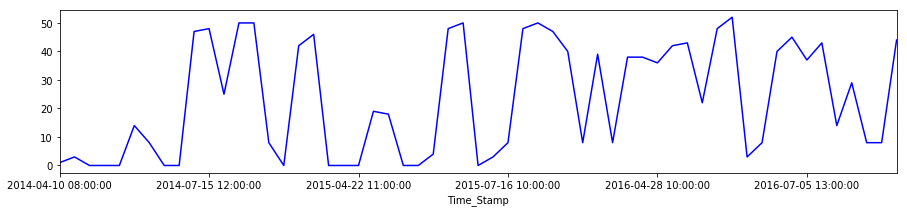

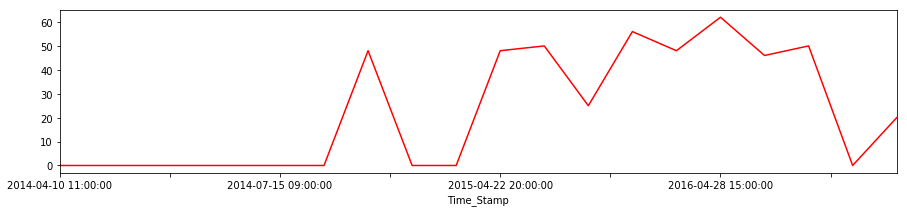

In [12]:
plt.figure(figsize=(15,3));
TRAIN.plot(color='blue')
plt.show();

plt.figure(figsize=(15,3));
TEST.plot(color='red',sharex=True)
plt.show()

## Modeling
### LSTM Recurrent Neural Network

To prepare the data for an LSTM network, i will have to create a x_train and y_train from the train part, and similarly for the test. the first entry of x_train should be TRAIN[0] and for y_train it should be TRAIN[1] because i am trying to predict the next value. I will have to discard the last value, as there is no y value for this entry.

In [41]:
# create train lists
x_train = []
y_train = []

# create test lists
x_test = []
y_test = []

# fill the train lists
for i in range(len(TRAIN)-1):
    x_train.append(TRAIN[i])
    y_train.append(TRAIN[i+1])

# fill the test lists
for i in range(len(TEST)-1):
    x_test.append(TEST[i])
    y_test.append(TEST[i+1])

# change the lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

print(x_train.shape)
print(x_test.shape)




(56,)
(19,)


In [14]:
trainX = x_train.reshape(x_train.shape[0], 1, 1)
trainY = y_train.reshape(y_train.shape[0], 1, 1)

In [43]:
x_train = x_train.reshape(1,56,1)
y_train = x_train.reshape(1,56,1)

x_test = x_test.reshape(1,19,1)
y_test = x_test.reshape(1,19,1)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

Using TensorFlow backend.
/home/bok/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [58]:
from sklearn import cross_validation
import datetime

#### two layer cross validation decision tree
#select X and Y                                                
x = x_train
y = y_train

# Tree complexity parameter - constraint on maximum depth
Denseness = np.arange(1, 120, )


# Initialize variable
NN_Error_train = np.empty((len(Denseness)))
NN_Error_test = np.empty((len(Denseness)))

  
# inner loop (model selection)
for i, t in enumerate(Denseness):
       
    model = Sequential()

    # adding layers
    model.add(LSTM(t, input_shape=(None,1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'linear'))

    # tweaking settings
    #adam = optimizers.Adam(lr=0.001, beta_1=0.9,
    #beta_2=0.999, epsilon=1e-08, decay=0.0)
    #model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
    
    # fitting model
    history = model.fit(x,y, validation_data=(x_test,y_test),
    epochs = 25, batch_size=500, shuffle=False,verbose=0)

    # predict
    y_est_test = model.predict(x_test, batch_size = 1000).reshape((-1,))
    y_est_train = model.predict(x_train, batch_size = 1000).reshape((-1,))

    #evaluate misclasification in the current Kfold
    misclass_rate_test = sum(np.abs(y_est_test - y_test.reshape(19))) / float(len(y_est_test))
    misclass_rate_train = sum(np.abs(y_est_train - y_train.reshape(56))) / float(len(y_est_train))
    NN_Error_test[i], NN_Error_train[i] = misclass_rate_test, misclass_rate_train


In [55]:
NN_Error_test.shape

(10,)

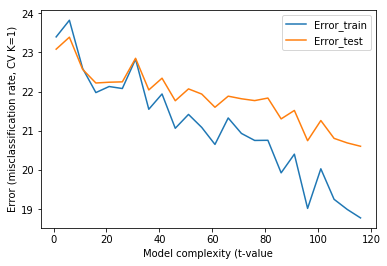

In [59]:
f = plt.figure()
plt.plot(Denseness, NN_Error_train)
plt.plot(Denseness, NN_Error_test)
plt.xlabel('Model complexity (t-value')
plt.ylabel('Error (misclassification rate, CV K={0})'.format(1))
plt.legend(['Error_train','Error_test'])
    
plt.show()

In [142]:
model = Sequential()
model.add(LSTM(95, input_shape=(None,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=500, batch_size=1, verbose=2,validation_data=(x_test, y_test))
y_pred = model.predict(x_test)

Train on 2 samples, validate on 1 samples
Epoch 1/500
 - 4s - loss: 27.6131 - acc: 0.1250 - val_loss: 23.1262 - val_acc: 0.0833
Epoch 2/500
 - 0s - loss: 27.3934 - acc: 0.1667 - val_loss: 22.8348 - val_acc: 0.0833
Epoch 3/500
 - 0s - loss: 27.0899 - acc: 0.1667 - val_loss: 22.5469 - val_acc: 0.0833
Epoch 4/500
 - 0s - loss: 26.8961 - acc: 0.1667 - val_loss: 22.2636 - val_acc: 0.0833
Epoch 5/500
 - 0s - loss: 26.6006 - acc: 0.1667 - val_loss: 21.9842 - val_acc: 0.0833
Epoch 6/500
 - 0s - loss: 26.4093 - acc: 0.1667 - val_loss: 21.7001 - val_acc: 0.0000e+00
Epoch 7/500
 - 0s - loss: 26.3034 - acc: 0.1250 - val_loss: 21.4077 - val_acc: 0.0000e+00
Epoch 8/500
 - 0s - loss: 25.9517 - acc: 0.1250 - val_loss: 21.1131 - val_acc: 0.0000e+00
Epoch 9/500
 - 0s - loss: 25.7100 - acc: 0.1250 - val_loss: 20.8097 - val_acc: 0.0000e+00
Epoch 10/500
 - 0s - loss: 25.6490 - acc: 0.1250 - val_loss: 20.4896 - val_acc: 0.0000e+00
Epoch 11/500
 - 0s - loss: 25.2010 - acc: 0.1250 - val_loss: 20.1589 - val_ac

Epoch 94/500
 - 0s - loss: 12.1592 - acc: 0.2083 - val_loss: 9.1337 - val_acc: 0.0833
Epoch 95/500
 - 0s - loss: 12.1439 - acc: 0.2500 - val_loss: 9.0665 - val_acc: 0.0000e+00
Epoch 96/500
 - 0s - loss: 12.0143 - acc: 0.2917 - val_loss: 8.9247 - val_acc: 0.0833
Epoch 97/500
 - 0s - loss: 12.2098 - acc: 0.1250 - val_loss: 8.5551 - val_acc: 0.1667
Epoch 98/500
 - 0s - loss: 11.8049 - acc: 0.1250 - val_loss: 8.4487 - val_acc: 0.1667
Epoch 99/500
 - 0s - loss: 11.7346 - acc: 0.1667 - val_loss: 8.5628 - val_acc: 0.0833
Epoch 100/500
 - 0s - loss: 11.6429 - acc: 0.2083 - val_loss: 8.5735 - val_acc: 0.0833
Epoch 101/500
 - 0s - loss: 11.2100 - acc: 0.1667 - val_loss: 8.5851 - val_acc: 0.0000e+00
Epoch 102/500
 - 0s - loss: 11.6489 - acc: 0.2500 - val_loss: 8.5705 - val_acc: 0.0000e+00
Epoch 103/500
 - 0s - loss: 11.3994 - acc: 0.1667 - val_loss: 8.3924 - val_acc: 0.0000e+00
Epoch 104/500
 - 0s - loss: 10.8700 - acc: 0.3333 - val_loss: 8.4143 - val_acc: 0.0000e+00
Epoch 105/500
 - 0s - loss: 1

Epoch 188/500
 - 0s - loss: 2.5264 - acc: 0.2083 - val_loss: 2.1406 - val_acc: 0.0833
Epoch 189/500
 - 0s - loss: 2.8428 - acc: 0.2500 - val_loss: 2.0312 - val_acc: 0.1667
Epoch 190/500
 - 0s - loss: 3.5097 - acc: 0.1667 - val_loss: 2.0006 - val_acc: 0.0833
Epoch 191/500
 - 0s - loss: 3.1015 - acc: 0.2500 - val_loss: 1.9069 - val_acc: 0.1667
Epoch 192/500
 - 0s - loss: 2.6754 - acc: 0.2083 - val_loss: 1.9007 - val_acc: 0.1667
Epoch 193/500
 - 0s - loss: 3.2051 - acc: 0.1667 - val_loss: 1.9946 - val_acc: 0.2500
Epoch 194/500
 - 0s - loss: 2.9228 - acc: 0.2083 - val_loss: 1.9763 - val_acc: 0.1667
Epoch 195/500
 - 0s - loss: 3.4080 - acc: 0.2083 - val_loss: 1.8906 - val_acc: 0.1667
Epoch 196/500
 - 0s - loss: 2.6737 - acc: 0.2500 - val_loss: 1.8786 - val_acc: 0.1667
Epoch 197/500
 - 0s - loss: 3.0963 - acc: 0.1667 - val_loss: 1.9782 - val_acc: 0.1667
Epoch 198/500
 - 0s - loss: 2.2130 - acc: 0.3333 - val_loss: 1.9996 - val_acc: 0.1667
Epoch 199/500
 - 0s - loss: 2.6853 - acc: 0.2083 - val

Epoch 284/500
 - 0s - loss: 1.6008 - acc: 0.3333 - val_loss: 2.3125 - val_acc: 0.3333
Epoch 285/500
 - 0s - loss: 1.6590 - acc: 0.2500 - val_loss: 2.3559 - val_acc: 0.2500
Epoch 286/500
 - 0s - loss: 2.4106 - acc: 0.2083 - val_loss: 2.4809 - val_acc: 0.1667
Epoch 287/500
 - 0s - loss: 1.8880 - acc: 0.2500 - val_loss: 2.5469 - val_acc: 0.0833
Epoch 288/500
 - 0s - loss: 1.3768 - acc: 0.3750 - val_loss: 2.4751 - val_acc: 0.0833
Epoch 289/500
 - 0s - loss: 1.4532 - acc: 0.4167 - val_loss: 2.3570 - val_acc: 0.1667
Epoch 290/500
 - 0s - loss: 1.4374 - acc: 0.3333 - val_loss: 2.3068 - val_acc: 0.2500
Epoch 291/500
 - 0s - loss: 1.6884 - acc: 0.2917 - val_loss: 2.4420 - val_acc: 0.1667
Epoch 292/500
 - 0s - loss: 1.4623 - acc: 0.2917 - val_loss: 2.6851 - val_acc: 0.0833
Epoch 293/500
 - 0s - loss: 1.2111 - acc: 0.4167 - val_loss: 2.7003 - val_acc: 0.0833
Epoch 294/500
 - 0s - loss: 1.3210 - acc: 0.4167 - val_loss: 2.5446 - val_acc: 0.1667
Epoch 295/500
 - 0s - loss: 1.6127 - acc: 0.3750 - val

Epoch 380/500
 - 0s - loss: 1.4454 - acc: 0.2917 - val_loss: 2.8677 - val_acc: 0.1667
Epoch 381/500
 - 0s - loss: 1.9138 - acc: 0.2083 - val_loss: 2.8411 - val_acc: 0.3333
Epoch 382/500
 - 0s - loss: 1.3453 - acc: 0.2083 - val_loss: 2.8054 - val_acc: 0.3333
Epoch 383/500
 - 0s - loss: 1.2783 - acc: 0.2500 - val_loss: 2.8381 - val_acc: 0.2500
Epoch 384/500
 - 0s - loss: 1.4121 - acc: 0.3750 - val_loss: 2.8770 - val_acc: 0.2500
Epoch 385/500
 - 0s - loss: 2.2449 - acc: 0.2500 - val_loss: 2.9058 - val_acc: 0.3333
Epoch 386/500
 - 0s - loss: 1.5320 - acc: 0.3750 - val_loss: 3.1103 - val_acc: 0.2500
Epoch 387/500
 - 0s - loss: 2.2889 - acc: 0.2917 - val_loss: 3.2335 - val_acc: 0.2500
Epoch 388/500
 - 0s - loss: 1.6385 - acc: 0.3333 - val_loss: 3.1352 - val_acc: 0.1667
Epoch 389/500
 - 0s - loss: 1.6414 - acc: 0.2083 - val_loss: 3.0618 - val_acc: 0.1667
Epoch 390/500
 - 0s - loss: 1.1886 - acc: 0.4167 - val_loss: 2.9209 - val_acc: 0.1667
Epoch 391/500
 - 0s - loss: 1.5157 - acc: 0.3750 - val

Epoch 476/500
 - 0s - loss: 1.5815 - acc: 0.2917 - val_loss: 2.6553 - val_acc: 0.1667
Epoch 477/500
 - 0s - loss: 1.1787 - acc: 0.3750 - val_loss: 2.7108 - val_acc: 0.1667
Epoch 478/500
 - 0s - loss: 1.1093 - acc: 0.4583 - val_loss: 2.7111 - val_acc: 0.1667
Epoch 479/500
 - 0s - loss: 1.8210 - acc: 0.2083 - val_loss: 2.8340 - val_acc: 0.0833
Epoch 480/500
 - 0s - loss: 1.5048 - acc: 0.2917 - val_loss: 2.8337 - val_acc: 0.0833
Epoch 481/500
 - 0s - loss: 1.6800 - acc: 0.2917 - val_loss: 2.7047 - val_acc: 0.1667
Epoch 482/500
 - 0s - loss: 1.2642 - acc: 0.3333 - val_loss: 2.6820 - val_acc: 0.1667
Epoch 483/500
 - 0s - loss: 1.5632 - acc: 0.3333 - val_loss: 2.6494 - val_acc: 0.1667
Epoch 484/500
 - 0s - loss: 1.4898 - acc: 0.2917 - val_loss: 2.6155 - val_acc: 0.1667
Epoch 485/500
 - 0s - loss: 1.5390 - acc: 0.2500 - val_loss: 2.7456 - val_acc: 0.0833
Epoch 486/500
 - 0s - loss: 1.4217 - acc: 0.2500 - val_loss: 2.9259 - val_acc: 0.0833
Epoch 487/500
 - 0s - loss: 1.3230 - acc: 0.2917 - val

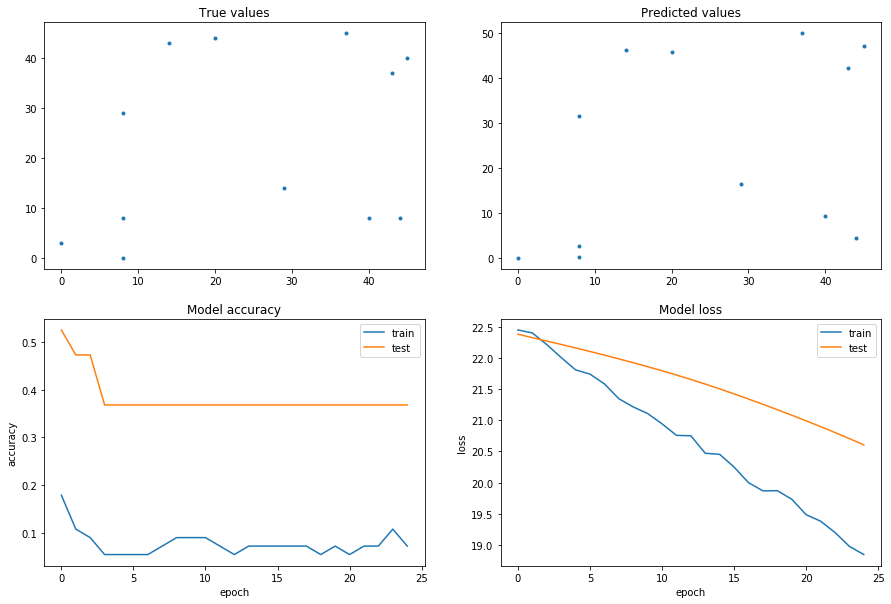

In [146]:
# true values plot
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(x_test.reshape(12),y_test.reshape(12), ls='', marker='.');
plt.title('True values');

# predicted values plotb
plt.subplot(2,2,2)
plt.plot(x_test.reshape(12),y_pred.reshape(12), ls='', marker='.');
plt.title('Predicted values');

# Visualize accuracy performance
plt.subplot(2,2,3)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')


# Visualize loss performance (MSE)
plt.subplot(2,2,4)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()


In [23]:
misclass_rate_test.shape

(19, 19)

In [24]:
NN_Error_test.shape

(10,)

In [61]:
sum(np.abs(y_est_train - y_train)) / float(len(y_est_train))

array([[  1.53901194e-02,   8.94083189e-03,   9.64351903e-03, ...,
          1.24577701e-01,   1.15573406e-01,   1.10360452e-01],
       [  5.11044051e-02,   4.46551176e-02,   4.53578047e-02, ...,
          8.88634154e-02,   7.98591205e-02,   7.46461664e-02],
       [  2.46702347e-03,   8.91631097e-03,   8.21362383e-03, ...,
          1.42434844e-01,   1.33430549e-01,   1.28217595e-01],
       ..., 
       [  5.15390119e-01,   5.08940832e-01,   5.09643519e-01, ...,
          3.75422299e-01,   3.84426594e-01,   3.89639548e-01],
       [  1.40390119e-01,   1.33940832e-01,   1.34643519e-01, ...,
          4.22298908e-04,   9.42659378e-03,   1.46395479e-02],
       [  1.40390119e-01,   1.33940832e-01,   1.34643519e-01, ...,
          4.22298908e-04,   9.42659378e-03,   1.46395479e-02]])

In [149]:
y_pred-y_test

array([[[-3.06876749],
        [ 0.07251677],
        [ 1.34475803],
        [ 7.18123245],
        [ 4.94470596],
        [ 5.19876099],
        [ 3.18650436],
        [ 2.53026581],
        [ 2.65812302],
        [-5.42852736],
        [-3.57313442],
        [ 1.7967186 ]]])

In [30]:
y_est_train.shape

(56,)

In [38]:
y_train.reshape(56).shape

(56,)

In [74]:
df['data'].shape

(77, 6)

In [103]:
data = pd.Series()
data['April14'] = df['data']['Full%'].loc['2014-04-10 08:00:00':'2014-04-10 20:00:00']
data['Jun14'] = df['data']['Full%'].loc['2014-07-15 08:00:00':'2014-07-15 20:00:00']
data['April15'] = df['data']['Full%'].loc['2015-04-22 08:00:00':'2015-04-22 20:00:00']
data['Jun15'] = df['data']['Full%'].loc['2015-07-16 08:00:00':'2015-07-16 20:00:00']
data['April16'] = df['data']['Full%'].loc['2016-04-28 08:00:00':'2016-04-28 20:00:00']
data['Jun16'] = df['data']['Full%'].loc['2016-07-05 08:00:00':'2016-07-05 20:00:00']


In [81]:
df['data']['Full%'].index

Index(['2014-04-10 08:00:00', '2014-04-10 09:00:00', '2014-04-10 10:00:00',
       '2014-04-10 11:00:00', '2014-04-10 12:00:00', '2014-04-10 13:00:00',
       '2014-04-10 14:00:00', '2014-04-10 15:00:00', '2014-04-10 16:00:00',
       '2014-04-10 17:00:00', '2014-04-10 18:00:00', '2014-04-10 19:00:00',
       '2014-04-10 20:00:00', '2014-07-15 08:00:00', '2014-07-15 09:00:00',
       '2014-07-15 10:00:00', '2014-07-15 11:00:00', '2014-07-15 12:00:00',
       '2014-07-15 13:00:00', '2014-07-15 14:00:00', '2014-07-15 15:00:00',
       '2014-07-15 16:00:00', '2014-07-15 17:00:00', '2014-07-15 18:00:00',
       '2014-07-15 19:00:00', '2014-07-15 20:00:00', '2015-04-22 08:00:00',
       '2015-04-22 09:00:00', '2015-04-22 10:00:00', '2015-04-22 11:00:00',
       '2015-04-22 12:00:00', '2015-04-22 13:00:00', '2015-04-22 14:00:00',
       '2015-04-22 15:00:00', '2015-04-22 16:00:00', '2015-04-22 17:00:00',
       '2015-04-22 18:00:00', '2015-04-22 19:00:00', '2015-04-22 20:00:00',
       '2015

In [115]:
for index in data.index.tolist():
    shape = data[index].shape
    print('The shape of {} is: {}'.format(index,shape))

The shape of April14 is: (13,)
The shape of Jun14 is: (13,)
The shape of April15 is: (13,)
The shape of Jun15 is: (13,)
The shape of April16 is: (12,)
The shape of Jun16 is: (13,)


In [87]:
data.index

Index(['1', '2', '3', '4', '5', '6'], dtype='object')

In [113]:
data.index

Index(['April14', 'Jun14', 'April15', 'Jun15', 'April16', 'Jun16'], dtype='object')

In [141]:
train = np.empty((2,13,1))
test = np.empty((1,13,1))

train[0] = data['Jun14'].values.reshape(13,1)
train[1] = data['Jun15'].values.reshape(13,1)

test = data['Jun16'].values.reshape(13,1)

# create train lists
x_train = np.empty((2,12,1))
y_train = np.empty((2,12,1))

x_train[0] = data['Jun14'].values[1:13].reshape(12,1)
y_train[0] = data['Jun14'].values[0:12].reshape(12,1)

x_train[1] = data['Jun15'].values[1:13].reshape(12,1)
y_train[1] = data['Jun15'].values[0:12].reshape(12,1)

# create test lists
x_test = np.empty((1,13,1))
y_test = np.empty((1,13,1))

x_test = data['Jun16'].values[1:13].reshape(1,12,1)
y_test = data['Jun16'].values[0:12].reshape(1,12,1)

print(x_train.shape)
print(x_test.shape)


(2, 12, 1)
(1, 12, 1)


In [92]:
X_train.shape

(2, 13, 1)

In [120]:
X_train[0] = data['Jun14'].values.reshape(13,1)
X_train[1] = data['Jun15'].values.reshape(13,1)
Y_train = data['Jun16'].values.reshape(1,13,1)


In [124]:
data['April14'].values.reshape(13,1)[1:13]

array([[  3.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [ 14.],
       [  8.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.]])

In [123]:
X_train[0].shape

(13, 1)

In [ ]:
y_train

In [125]:
data['April14'].values.reshape(13,1)

array([[  1.],
       [  3.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [ 14.],
       [  8.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.]])

In [128]:
data['April14'].values.shape

(13,)

In [132]:
data['April14'].values.shape

(13,)